# How outliers in equity returns can affect correlations
This is a simple python script I created to use in a project to analyze the correlation of stocks. My assumption was that big market moves that happened often would cause equities within certain groups to be more correlated. If you were to remove those days where the stocks have the most unusual moves their correlation might change. Some of the equties and markets that I looked at for this project did expereince stronger correlations due to their outliers. Take a look.

In [2]:
import pandas as pd
import datetime
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import numpy as np
import operator
from scipy.stats.mstats import mquantiles
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


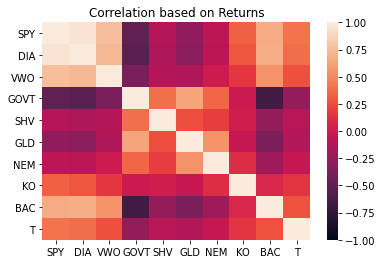

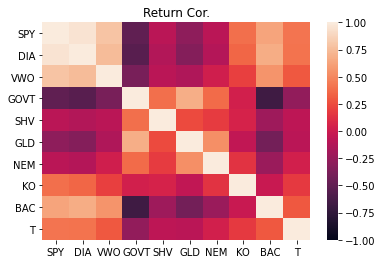

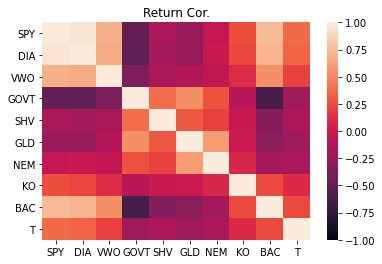

In [3]:
def get_single_stock_data(start_date, end_date, symbol):
    data = web.DataReader(symbol, "yahoo", start_date, end_date)
    return data

start_date = datetime.datetime(2019, 8, 1)
end_date = datetime.datetime(2020, 8, 1)

d1_rtrn = lambda x : x['Adj Close'].pct_change(1).dropna()
datad = lambda x,start_date,end_date : get_single_stock_data(start_date,end_date,x)
def prtf_indv_rtrns(prtf_tkrs):
    start = 2019
    end = 2020
    start_date = datetime.datetime(start, 1, 1)
    end_date = datetime.datetime(end, 1, 1)
    x = d1_rtrn(datad(prtf_tkrs[0], start_date, end_date))
    df = pd.DataFrame(x)
    for i in range(1, len(prtf_tkrs)):
        y = d1_rtrn(datad(prtf_tkrs[i], start_date, end_date))
        df1 = pd.DataFrame(y)
        df = pd.concat([df, df1['Adj Close']], axis=1)
    df.columns = prtf_tkrs
    return df

def outlier(df):
    outliers = pd.DataFrame()
    for i in range(len(df.columns)):
        df2 = pd.DataFrame(df.iloc[:, (i)])
        for x in range(251):
            rtn = df2.iloc[x-1]
            if np.abs(rtn[0]) < np.abs(mquantiles(df2, [0.25])) or np.abs(rtn[0]) > np.abs(mquantiles(df2, [0.75])):
                out = pd.DataFrame(df.iloc[x, :])
                outliers = pd.concat([outliers, out], axis=1)
        return outliers

def reverse_outlier(df):
    outliers = pd.DataFrame()
    for i in range(len(df.columns)):
        df2 = pd.DataFrame(df.iloc[:, (i)])
        for x in range(251):
            rtn = df2.iloc[x-1]
            if np.abs(rtn[0]) < np.abs(mquantiles(df2, [0.75])) and np.abs(rtn[0]) > np.abs(mquantiles(df2, [0.25])):
                out = pd.DataFrame(df.iloc[x, :])
                outliers = pd.concat([outliers, out], axis=1)
        return outliers

def pivot(df):
    pivot = pd.DataFrame()
    for i in range(len(df.columns)):
        df2 = pd.DataFrame(df.iloc[:, (i)])
        for x in range(251):
            out = pd.DataFrame(df.iloc[x, :])
            pivot = pd.concat([pivot, out], axis=1)
        return pivot

def plt_heatmap(df, title):
    a = pd.DataFrame()
    for i in range(df.shape[0]):
        b = pd.DataFrame(df.iloc[i])
        a = pd.concat([a, b], axis=1)
    data = pd.DataFrame(a.corr())
    sns.heatmap(data, vmin=-1, vmax=1,
                xticklabels=data.columns,
                yticklabels=data.columns)
    plt.title(title)
    return plt.show()

#A list of the tickers that we will be looking at for our correlation analysis 
tickers = ['SPY', 'DIA', 'VWO', 'GOVT', 'SHV','GLD', 'NEM', 'KO', 'BAC', 'T']
#getting the daily returns for the tickers we selected 
test = pd.DataFrame(prtf_indv_rtrns(tickers))
#adjusting the data and finding the outliers 
test1 = pd.DataFrame(pivot(test))
test_o = pd.DataFrame(outlier(test))
test_ro = pd.DataFrame(reverse_outlier(test))
#mapping the outliers
plt_heatmap(test1, "Correlation based on Returns")
plt_heatmap(test_o, "Return Cor.")
plt_heatmap(test_ro, "Return Cor.")
#print(test1)
#print(test_o)
#print(test_ro)

After examing these correlations we found it appropriate to see how they change over time. 

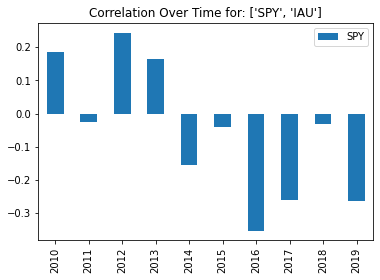

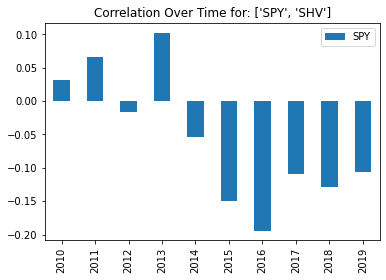

In [4]:
def correlation_over_time(prtf_tkrs, num_yrs):
    start = 2010
    end = 2011
    corr_yr = pd.DataFrame()
    for i in range(num_yrs):
        start_date = datetime.datetime(start, 1, 1)
        end_date = datetime.datetime(end, 1, 1)
        x = d1_rtrn(datad(prtf_tkrs[0], start_date, end_date))
        df = pd.DataFrame(x)
        for i in range(1, len(prtf_tkrs)):
            y = d1_rtrn(datad(prtf_tkrs[i], start_date, end_date))
            df1 = pd.DataFrame(y)
            df = pd.concat([df, df1['Adj Close']], axis=1)
        df.columns = prtf_tkrs
        corr = df.corr()
        corr.columns = ['SPY', start]
        corr_yr = pd.concat([corr_yr, corr[start]], axis=1, sort=True)
        start += 1
        end += 1
    return corr_yr

tickers = ['SPY', 'IAU']
tickers2 = ['SPY', 'SHV']

correlationgraph = pd.DataFrame(correlation_over_time(tickers, 10).loc['SPY'])
correlationgraph.plot.bar()
plt.title('Correlation Over Time for: ' + str(tickers))
correlationgraph2 = pd.DataFrame(correlation_over_time(tickers2, 10).loc['SPY'])
correlationgraph2.plot.bar()
plt.title('Correlation Over Time for: ' + str(tickers2))
plt.show()